# 프로젝트: CAM을 만들고 평가해 보자

목표 : CAM과 Grad-CAM 구현하고 평가하기   

<img src="./images/g10_3.png" width="70%" height="70%" align="left"></img>  

## 0. 데이터 셋 가져오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/8144 [00:00<?, ? examples/s]

Shuffling cars196-train.tfrecord...:   0%|          | 0/8144 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8041 [00:00<?, ? examples/s]

Shuffling cars196-test.tfrecord...:   0%|          | 0/8041 [00:00<?, ? examples/s]

Dataset cars196 downloaded and prepared to /aiffel/tensorflow_datasets/cars196/2.0.0. Subsequent calls will reuse this data.


In [4]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

테스트 데이터 셋 중 하나를 가져와서 시각화

In [5]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


13


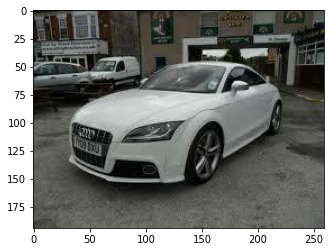

In [7]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

이전 시간에서 훈련한 모델 가져오기 

In [8]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

## 1. CAM 구현하기  
*Step설명 : 1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.*

- 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의 
- feedforward를 거친 후 CAM을 계산하도록 구현
- 입력 이미지의 크기에 맞춰 CAM을 resize 

In [11]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

*Step설명 : 2) 만든 함수로 CAM 이미지를 생성합시다.*

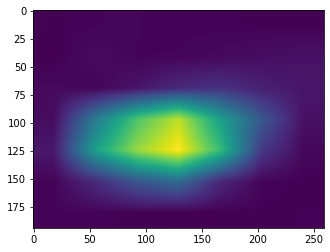

In [12]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

*Step 설명 : 3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.  
참고: webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩  https://webnautes.tistory.com/1245*

In [14]:
# 이미지 원본과 CAM겹쳐보여주는 함수 
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

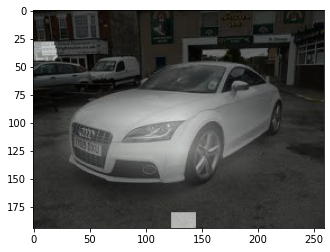

In [15]:
# visualize_cam_on_image() 함수 사용
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 2. Grad-CAM 구현하기
*Step설명 : 1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.*

In [16]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

*Step설명 : 2) 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.*

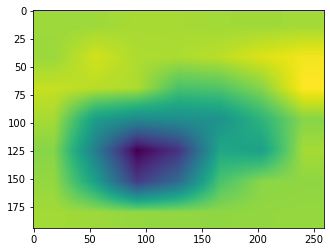

In [17]:
grad_cam_image1 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image1)

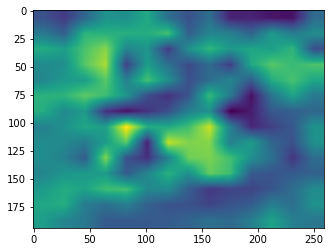

In [18]:
grad_cam_image2 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image2)

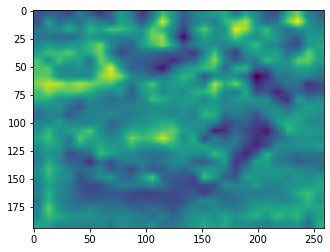

In [19]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image3)

*Step설명 : 3) 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.*

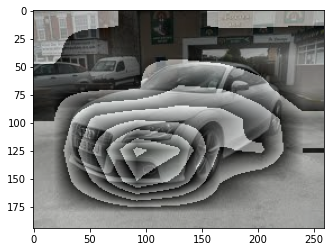

In [20]:
cam_image_3channel = np.stack([grad_cam_image1*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

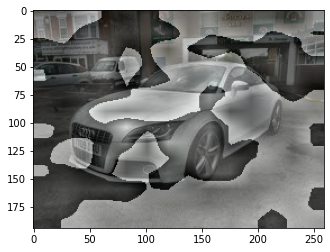

In [21]:
cam_image_3channel = np.stack([grad_cam_image2*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

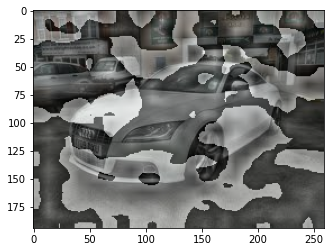

In [22]:
cam_image_3channel = np.stack([grad_cam_image3*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 3. IoU 구하기
*Step설명 : 1) 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.*



### 3-1. 바운딩 박스 그리기

In [23]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

CAM 바운딩 박스

In [24]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ -6,  67],
       [255,  38],
       [268, 159],
       [  6, 189]])

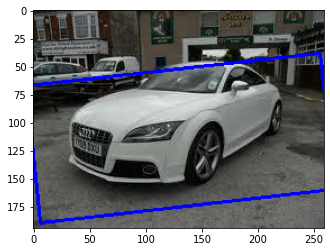

In [39]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

Grad-CAM 바운딩 박스

In [46]:
gc_image = copy.deepcopy(item['image'])
gc_rect = get_bbox(grad_cam_image1)
gc_rect

array([[ -1,  19],
       [257,  12],
       [259,  87],
       [  0,  94]])

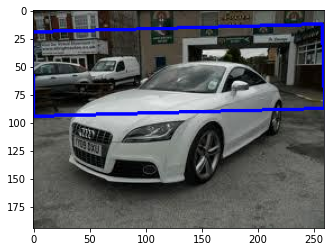

In [47]:
gc_image = cv2.drawContours(gc_image,[gc_rect],0,(0,0,255),2)
plt.imshow(gc_image)

### 3-2 IOU 비교 

In [32]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [33]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.1958762886597938,
 -0.023166023166023165,
 0.9742268041237113,
 1.0347490347490347]

In [34]:
gc_pred_bbox = rect_to_minmax(gc_rect, item['image'])
gc_pred_bbox

[0.061855670103092786, -0.003861003861003861, 0.4845360824742268, 1.0]

In [35]:
item['bbox']

array([0.22680412, 0.11969112, 0.80927837, 0.87258685], dtype=float32)

In [36]:
def get_iou(gt_bbox, pred_bbox):
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min= max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    boxBArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

*Step설명 : 2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.*

CAM IoU

In [37]:
get_iou(pred_bbox, item['bbox'])

0.5325808411909521

Grad-CAM IoU

In [38]:
get_iou(gc_pred_bbox, item['bbox'])

0.29013538100599207

CAM에서 얻은 바운딩 박스와의 IoU가 더 높다. 

## 느낀점
CAM(Class Activation Map)을 배우는 시간이였다.   
클래스가 활성화되는 지도를 나타낸 것으로 모델이 어떤 곳을 보고 각 클래스임을 짐작하고 있는지를 확인할 수 있다.  
레이어마다 feature map을 시각화해서, activation이 어떻게 됬는지 확인해 볼 수 있는 것으로 모델을 설명할 수 있다는 것이 신기했다.   
이전 시간에서 ResNet + GAP + DenseLayer로 학습시킨 모델을 가져와서, CAM과 Grad-CAM을 구현해보고 시각화해보았다.   
또한 IoU로 평가도 해보았다. IoU는 실제 바운딩 박스와 예측 바운딩 박스의 합집합으로 교집합을 나눈값이다.   
Grad-CAM보다는 CAM이 좀 더 나은 값을 보였다.   